In [1]:
# import packages 

import numpy as np
import os
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
#import tables
%matplotlib inline


# folder path and name
project_path = os.getcwd()
data_folder = os.path.join(os.getcwd(),'data')
pred_folder = os.path.join(data_folder,'data_forecast')
pv_data_path = os.path.join(data_folder,'pv_data','pv_output_valid.pkl')

image_name_format = '%Y%m%d%H%M%S'

# Operating parameter
stack_height = 15 # 15 minute
forecast_horizon = 15 # 15 minutes ahead forecast
forecast_horizons = [15, 30, 45, 60]
sampling_interval_all = [2]
output_img_shape = [224, 224, 3]

start_date = datetime.datetime(2017,1,1) #NOTE: Inclusive of start date
end_date = datetime.datetime(2018,1,1) #NOTE: Exclusive of end date (only end up with 2017 data)

In [2]:
# Setting up test set
sunny_day = [(2017,9,15),(2017,10,6),(2017,10,22),(2018,2,16),(2018,6,12),(2018,6,23),(2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_day = [(2017,6,24),(2017,9,20),(2017,10,11),(2018,1,25),(2018,3,9),(2018,10,4),(2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_datetime = [datetime.datetime(day[0],day[1],day[2]) for day in sunny_day]
cloudy_datetime = [datetime.datetime(day[0],day[1],day[2]) for day in cloudy_day]
test_dates = sunny_datetime + cloudy_datetime

In [3]:
test_dates

[datetime.datetime(2017, 9, 15, 0, 0),
 datetime.datetime(2017, 10, 6, 0, 0),
 datetime.datetime(2017, 10, 22, 0, 0),
 datetime.datetime(2018, 2, 16, 0, 0),
 datetime.datetime(2018, 6, 12, 0, 0),
 datetime.datetime(2018, 6, 23, 0, 0),
 datetime.datetime(2019, 1, 25, 0, 0),
 datetime.datetime(2019, 6, 23, 0, 0),
 datetime.datetime(2019, 7, 14, 0, 0),
 datetime.datetime(2019, 10, 14, 0, 0),
 datetime.datetime(2017, 6, 24, 0, 0),
 datetime.datetime(2017, 9, 20, 0, 0),
 datetime.datetime(2017, 10, 11, 0, 0),
 datetime.datetime(2018, 1, 25, 0, 0),
 datetime.datetime(2018, 3, 9, 0, 0),
 datetime.datetime(2018, 10, 4, 0, 0),
 datetime.datetime(2019, 5, 27, 0, 0),
 datetime.datetime(2019, 6, 28, 0, 0),
 datetime.datetime(2019, 8, 10, 0, 0),
 datetime.datetime(2019, 10, 19, 0, 0)]

In [4]:
def find_idx_with_dates(all_times,test_dates):
    idx=[]
    for test_day in test_dates:
        test_day_end = test_day + datetime.timedelta(days = 1)
        idx+=np.nonzero((all_times>test_day)*(all_times<test_day_end))[0].tolist()
    return idx

# This two function does the same thing. Just that one is for np, the other for pd.

def find_time_within_nparray(time_array,time_point):
    probable_idx = np.searchsorted(time_array,time_point)
    
    # If the time point is after all the time in pv_data
    if probable_idx == len(time_array):
        return None   
    
    # See if the time point is actually a match 
    if time_array[probable_idx]== time_point: 
        return probable_idx
        
    else:
        return None

def find_time_within_pdseries(time_array,time_point):
    probable_idx = np.searchsorted(time_array,time_point)
    
    # If the time point is after all the time in pv_data
    if probable_idx == len(time_array):
        return None   
    
    # See if the time point is actually a match 
    if time_array[probable_idx] == time_point: 
        return probable_idx
        
    else:
        return None

In [5]:
def store_trainval_test(all_times,image_log,pv_log,pv_pred,pred_folder):
    
    ## Splitting into Trainval and Test set 
    idx_test = find_idx_with_dates(all_times,test_dates)
    image_log_test = image_log[idx_test]
    pv_log_test = pv_log[idx_test]
    pv_pred_test = pv_pred[idx_test]
    times_test = all_times[idx_test]

    # the rest become the trainval set
    mask_trainval = np.ones_like(pv_pred,dtype = bool)
    mask_trainval[idx_test] = 0
    image_log_trainval = image_log[mask_trainval]
    pv_log_trainval = pv_log[mask_trainval]
    pv_pred_trainval = pv_pred[mask_trainval]
    times_trainval = all_times[mask_trainval]
    
    print("times_trainval.shape",times_trainval.shape)
    print("image_log_trainval.shape",image_log_trainval.shape)
    print("pv_log_trainval.shape",pv_log_trainval.shape)
    print("pv_pred_trainval.shape",pv_pred_trainval.shape)
    
    print("times_test.shape",times_test.shape)
    print("image_log_test.shape",image_log_test.shape)
    print("pv_log_test.shape",pv_log_test.shape)
    print("pv_pred_test.shape",pv_pred_test.shape)
    
    ## Storing information
    # storing the training set
    np.save(os.path.join(pred_folder,'image_log_trainval.npy'), image_log_trainval)
    np.save(os.path.join(pred_folder,'pv_log_trainval.npy'), pv_log_trainval)
    np.save(os.path.join(pred_folder,'pv_pred_trainval.npy'),pv_pred_trainval)
    np.save(os.path.join(pred_folder,'times_trainval.npy'),times_trainval)

    # storing the testing set
    np.save(os.path.join(pred_folder,'image_log_test.npy'), image_log_test)
    np.save(os.path.join(pred_folder,'pv_log_test.npy'), pv_log_test)
    np.save(os.path.join(pred_folder,'pv_pred_test.npy'),pv_pred_test)
    np.save(os.path.join(pred_folder,'times_test.npy'),times_test)

In [6]:
# Load in  high frequency data
# the image here are ones that have corresponding PV value
all_times = np.load(os.path.join(data_folder,'data_expanded','all_times_highfreq.npy'), allow_pickle=True)
all_images = np.load(os.path.join(data_folder,'data_expanded','all_images_highfreq.npy'), allow_pickle=True)
pv_data = np.load(pv_data_path, allow_pickle=True)
#pv_data = np.load(os.path.join(data_folder,'data_expanded','pv_outputs_highfreq.npy'), allow_pickle=True)

# only pick out the relevant time period
#relevant_mask = (all_times>=start_date)&(all_times<end_date)
#all_times = all_times[relevant_mask]
#all_images = all_images[relevant_mask]
#pv_data = pv_data[start_date:end_date]
idx_test = find_idx_with_dates(all_times,test_dates)
n_images = all_times.shape[0]


In [7]:
all_times_np = np.array(all_times, dtype = 'datetime64[ns]')
print(all_times_np)

['2017-03-09T06:47:00.000000000' '2017-03-09T06:48:00.000000000'
 '2017-03-09T06:49:00.000000000' ... '2019-10-26T17:57:20.000000000'
 '2019-10-26T17:58:20.000000000' '2019-10-26T17:59:20.000000000']


In [8]:
print(n_images)

363375


In [9]:
def get_subarray_between_values(arr, a, b):
    """
    Returns a subarray containing elements from 'arr' that are
    greater than 'a' and less than 'b'.

    Args:
        arr (numpy.ndarray): The input NumPy array.
        a (int or float): The lower bound (exclusive).
        b (int or float): The upper bound (exclusive).

    Returns:
        numpy.ndarray: A new NumPy array containing the filtered elements.
    """
    # Create a boolean mask where elements are greater than 'a'
    mask_greater_than_a = arr >= a

    # Create a boolean mask where elements are less than 'b'
    mask_less_than_b = arr < b

    # Combine the masks using the logical AND operator
    # An element must satisfy both conditions to be included
    combined_mask = mask_greater_than_a & mask_less_than_b

    # Use the combined mask to select the elements from the original array
    subarray = arr[combined_mask]

    return subarray


In [17]:
# Create forecast training data file
import h5py
import hdf5plugin
#mmap_array = np.memmap('video_prediction_224.dat', dtype='uint8', mode='w+', shape=(n_images, 224, 224, 3))
sampling_interval = 2

n_valid = 307518 # index 307517 is the last valid index
test_n = 10000
#n_trainval = 149680
n_trainval=4712
n_test = 6145
chunk_shape = (1, stack_height+1, *output_img_shape)

#batch_size = 8000
batch_size = 6000
testing = True
#for sampling_interval in sampling_interval_all:
resume_idx = 0
use_compression = False


with h5py.File('data/video_prediction_224_testing.h5', 'w') as f:

	if resume_idx and 'image_log' in f:
	# Resume mode - datasets already exist
		image_log_ds = f['image_log']
		pv_log_ds = f['pv_log'] 
		pv_pred_ds = f['pv_pred']
		print(f"Resuming from existing datasets. Current size: {image_log_ds.shape[0]}")

	# First run - create new datasets
	else:
		trainval_group = f.create_group('trainval')
		test_group = f.create_group('test')
		image_log_trainval_ds = trainval_group.create_dataset(
			'image_log',
			shape=(n_trainval, stack_height+1, *output_img_shape),
			chunks=chunk_shape,
			compression=hdf5plugin.Blosc2(cname='zstd', clevel=1, filters=1) if use_compression else None,
			dtype='uint8'
		)
		pv_log_trainval_ds = trainval_group.create_dataset(
			'pv_log',
			shape=(n_trainval, stack_height+1),
			dtype='float32' 
		)
		pv_pred_trainval_ds = trainval_group.create_dataset(
			'pv_pred',
			shape=(n_trainval,),
			dtype='float32'
		)
		'''times_trainval_ds = trainval_group.create_dataset(
			'times',
			shape=(n_trainval,),
			dtype='datetime64[ns]'
		)''' # import times from npy file instead
		image_log_test_ds = test_group.create_dataset(
			'image_log',
			shape=(n_test, stack_height+1, *output_img_shape),
			chunks=chunk_shape,
			compression=hdf5plugin.Blosc2(cname='zstd', clevel=1, filters=1) if use_compression else None,
			dtype='uint8'
		)
		pv_log_test_ds = test_group.create_dataset(
			'pv_log',
			shape=(n_test, stack_height+1),
			dtype='float32'
		)
		pv_pred_test_ds = test_group.create_dataset(
			'pv_pred',
			shape=(n_test,),
			dtype='float32'
		)
		'''times_test_ds = test_group.create_dataset(
			'times',
			shape=(n_test,),
			dtype='datetime64[ns]'
		)'''
		print("Creating new datasets")

	
	#image_log = np.empty([0,stack_height+1]+output_img_shape,dtype = 'uint8')
	#pv_log = np.empty([0, stack_height+1])
	#pv_pred = np.empty([0])
	
	last_valid_index=0

	last_valid_index = 0
	curr_trainval_size = 0
	curr_test_size = 0

	tic = time.process_time()
	print("breh: ", test_n if testing else n_valid)
	for b in range(resume_idx if (resume_idx and 'image_log' in f) else 0, test_n if testing else n_valid, batch_size):
		current_batch_size =  min(batch_size, n_valid-b)
		# Initialize variables to save pv values
		#image_log_batch = np.zeros([n_images,stack_height+1]+output_img_shape,dtype = 'uint8')
		idx_test_batch = get_subarray_between_values(np.asarray(idx_test),b,b+current_batch_size)

		image_log_batch = np.zeros([current_batch_size,stack_height+1]+output_img_shape,dtype = 'uint8')
		
		#all_times_batch = all_times[b*batch_size : b*batch_size + current_batch_size]
		pv_log_batch = np.zeros((current_batch_size,stack_height+1))
		pv_pred_batch = np.zeros(current_batch_size)
		validity_mask = np.ones(current_batch_size,dtype = bool)
		
		

		sampling_interval_td = datetime.timedelta(minutes = sampling_interval) - datetime.timedelta(seconds=1)
		for i in range(current_batch_size):
			count = b+i

			
			# See if the specified sampling frequency is met 
			if all_times[count] - all_times[last_valid_index] > sampling_interval_td:

				# Collecting groud truth for predicted value
				pred_time = all_times[count]+datetime.timedelta(minutes=forecast_horizon)
				
				pv_pred_idx = find_time_within_nparray(pv_data.index,pred_time)
				if pv_pred_idx is None:# if prediction ground truth not found
					validity_mask[i] = False
					#print(all_times[i],'has no PV pred')
				else: 
					pv_pred_batch[i] = pv_data.iloc[pv_pred_idx] 

				# Collecting image log and PV log
				for j in range(stack_height+1):
					log_time = all_times[count] - datetime.timedelta(minutes = j)
					# Collecting a stack of image
					log_time_idx = find_time_within_nparray(all_times,log_time)
					if log_time_idx is not None:
						image_log_batch[i,j] = all_images[log_time_idx]
					else:
						validity_mask[i] = False
						#print(all_times[count],'has no image log')
						break

					# Collecting a stack of PV value
					pv_log_idx = find_time_within_nparray(pv_data.index,log_time)
					# Check if PV value present
					if pv_log_idx is None:
						validity_mask[i] = False
						#print(all_times[count],'has no PV log')
						break
					else: 
						pv_log_batch[i,j] = pv_data.iloc[pv_log_idx]    

			else: # if this is in between the sampling points, discard
				validity_mask[i] = False
			
			if validity_mask[i]:
				last_valid_index = count
			
		# Prompt progress of current work

		print('processed {0}/{1} images'.format(b+current_batch_size,len(all_times)))
			
		
		# Only pick out the valid time points
		#all_times_batch = all_times_batch[validity_mask]
		test_mask = np.zeros(current_batch_size, dtype=bool)
		test_mask[idx_test_batch-b] = True
		validity_test_mask = validity_mask & test_mask
		trainval_mask = np.ones(current_batch_size, dtype=bool)
		trainval_mask[idx_test_batch-b] = False
		validity_trainval_mask = validity_mask & trainval_mask

		image_log_trainval_batch = image_log_batch[validity_trainval_mask]
		pv_log_trainval_batch = pv_log_batch[validity_trainval_mask]
		pv_pred_trainval_batch = pv_pred_batch[validity_trainval_mask]

		image_log_test_batch = image_log_batch[validity_test_mask]
		pv_log_test_batch = pv_log_batch[validity_test_mask]
		pv_pred_test_batch = pv_pred_batch[validity_test_mask]
		# Store information
		
		print("storing data")
		#image_log_ds[curr_size:curr_size+validity_mask.sum()] = image_log_batch
		#pv_log_ds[curr_size:curr_size+validity_mask.sum()] = pv_log_batch
		#pv_pred_ds[curr_size:curr_size+validity_mask.sum()] = pv_pred_batch

		num_valid_trainval = validity_trainval_mask.sum()
		num_valid_test = validity_test_mask.sum()
		print("num_valid_trainval: ",num_valid_trainval)
		print("num_valid_test: ",num_valid_test)
		image_log_trainval_ds[curr_trainval_size:curr_trainval_size+validity_trainval_mask.sum()] = image_log_trainval_batch
		#print("image_log_trainval_batch: ",image_log_trainval_batch)
		#print("image_log_trainval_ds.shape: ",image_log_trainval_ds.shape)
		print("stored trainval image log")
		pv_log_trainval_ds[curr_trainval_size:curr_trainval_size+validity_trainval_mask.sum()] = pv_log_trainval_batch
		print("stored trainval pv log")
		pv_pred_trainval_ds[curr_trainval_size:curr_trainval_size+validity_trainval_mask.sum()] = pv_pred_trainval_batch
		print("stored trainval pv pred")
		image_log_test_ds[curr_test_size:curr_test_size+validity_test_mask.sum()] = image_log_test_batch
		print("stored test image log")
		pv_log_test_ds[curr_test_size:curr_test_size+validity_test_mask.sum()] = pv_log_test_batch
		pv_pred_test_ds[curr_test_size:curr_test_size+validity_test_mask.sum()] = pv_pred_test_batch

		curr_trainval_size += num_valid_trainval
		#print("trainval_size: ",validity_trainval_mask.sum())
		curr_test_size += num_valid_test
		#print("test_size: ",validity_test_mask.sum())

		print('For sampling frequency: ',sampling_interval,' minutes')
		#print('Expected finishing time:', datetime.datetime.now()+
		#		datetime.timedelta(seconds = (time.process_time() - tic)*(len(all_times)/(b+batch_size))))
		f.flush()
		del image_log_trainval_batch
		del pv_log_trainval_batch
		del pv_pred_trainval_batch
		del image_log_test_batch
		del pv_log_test_batch
		del pv_pred_test_batch


Creating new datasets
breh:  10000
processed 6000/363375 images
storing data
num_valid_trainval:  2274
num_valid_test:  0
stored trainval image log
stored trainval pv log
stored trainval pv pred
stored test image log
For sampling frequency:  2  minutes
processed 12000/363375 images
storing data
num_valid_trainval:  2438
num_valid_test:  0
stored trainval image log
stored trainval pv log
stored trainval pv pred
stored test image log
For sampling frequency:  2  minutes


In [18]:
import h5py
import hdf5plugin
f = h5py.File('data/video_prediction_224_testing.h5', 'r')

In [ ]:
print(image_log[])

(10000, 16, 224, 224, 3)


24.141178
17.532612


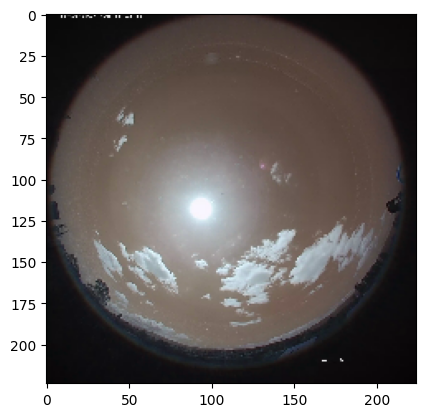

16.235596
11.881411


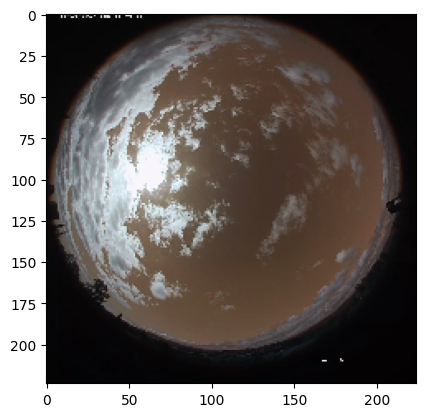

23.180021
16.949465


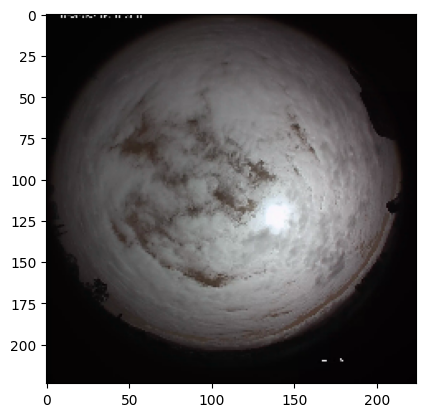

IndexError: Index (4720) out of range for (0-4711)

In [19]:
import time
image_log = f['trainval']['image_log']
pv_log = f['trainval']['pv_log']
pv_pred = f['trainval']['pv_pred']
for i in range(0, 5000, 20):
	if pv_log[i][15]-pv_pred[i] > 4:
		print(pv_log[i][15])
		print(pv_pred[i])
		arr = np.array(image_log[i][15])


		plt.imshow(arr, cmap=None, interpolation=None, aspect=None)

		plt.show()
	

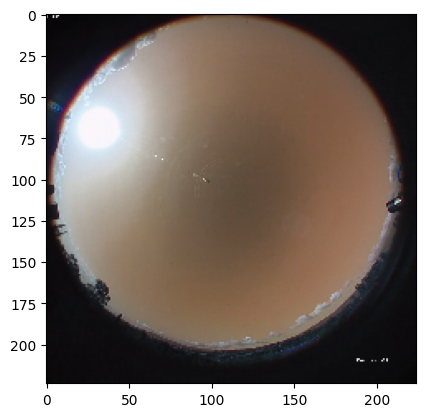

In [15]:
arr2 = np.array(image_log[305][1])

plt.imshow(arr, cmap=None, interpolation=None, aspect=None)
plt.imshow(arr2, cmap=None, interpolation=None, aspect=None)
plt.show()

In [14]:
pv_log = f['trainval']['pv_log']

In [21]:
print(pv_log[305][2])

2.0761724


In [16]:
print(curr_trainval_size, curr_trainval_size+validity_trainval_mask.sum())

4712 7150


In [ ]:
print(image_log_batch[validity_trainval_mask].shape)

(6000, 16, 224, 224, 3)


In [13]:
a=np.array([1,2,3,4,5,6,7,8,9,0])
b=np.array([True,False,True,True,False,True,True,True,True,True])
print(b.sum())

print(a[b])

8
[1 3 4 6 7 8 9 0]
